In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [3]:
def conv_block(x, filters, kernel_size, strides=2):
    """
    Convolutional block with shortcut connection for downsampling.
    """
    # Shortcut
    shortcut = Conv2D(filters * 4, kernel_size=(1, 1), strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    # First convolution
    x = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut and pass through activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [4]:

def identity_block(x, filters, kernel_size):
    """
    Identity block with no downsampling.
    """
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut and pass through activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [5]:
def resnet50(input_shape=(224, 224, 3), num_classes=1000):
    """
    Builds the ResNet-50 model from scratch.
    """
    inputs = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    # Conv Block + Identity Blocks
    x = conv_block(x, filters=64, kernel_size=3, strides=1)  # Block 1
    for _ in range(2):
        x = identity_block(x, filters=64, kernel_size=3)

    x = conv_block(x, filters=128, kernel_size=3)  # Block 2
    for _ in range(3):
        x = identity_block(x, filters=128, kernel_size=3)

    x = conv_block(x, filters=256, kernel_size=3)  # Block 3
    for _ in range(5):
        x = identity_block(x, filters=256, kernel_size=3)

    x = conv_block(x, filters=512, kernel_size=3)  # Block 4
    for _ in range(2):
        x = identity_block(x, filters=512, kernel_size=3)

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [6]:
# Define model for CIFAR-10 with 10 classes
model = resnet50(input_shape=(32, 32, 3), num_classes=10)
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │      4,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │     16,640 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 256) │     16,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 256) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     16,448 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 347s 419ms/step - accuracy: 0.3146 - loss: 2.2683 - val_accuracy: 0.2230 - val_loss: 24.9161
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 300s 384ms/step - accuracy: 0.4584 - loss: 1.6953 - val_accuracy: 0.1446 - val_loss: 161.7186
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 302s 386ms/step - accuracy: 0.4811 - loss: 1.6381 - val_accuracy: 0.1978 - val_loss: 2.7901
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 300s 383ms/step - accuracy: 0.3589 - loss: 2.0185 - val_accuracy: 0.3600 - val_loss: 2.5419
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 305s 391ms/step - accuracy: 0.4095 - loss: 1.8222 - val_accuracy: 0.4421 - val_loss: 1.8526
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 303s 387ms/step - accuracy: 0.4534 - loss: 1.6733 - val_accuracy: 0.3149 - val_loss: 21.3685
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 385s 492ms/step - accuracy: 0.4428 - loss: 1.7015 - val_accuracy: 0.3905 - val_loss: 2.4092
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 510s 653ms/step - accuracy: 0.46

In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 - 14s - 43ms/step - accuracy: 0.6327 - loss: 1.3236
Test Accuracy: 63.27%


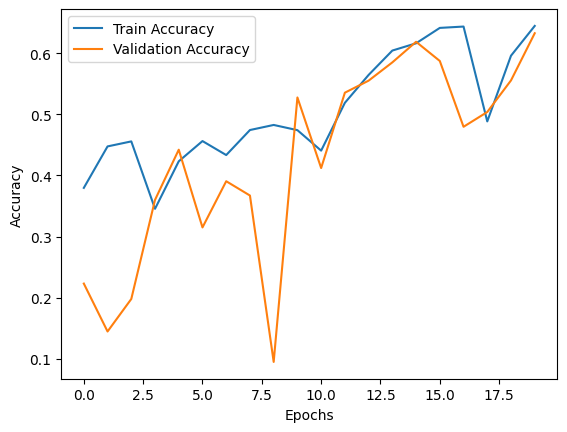

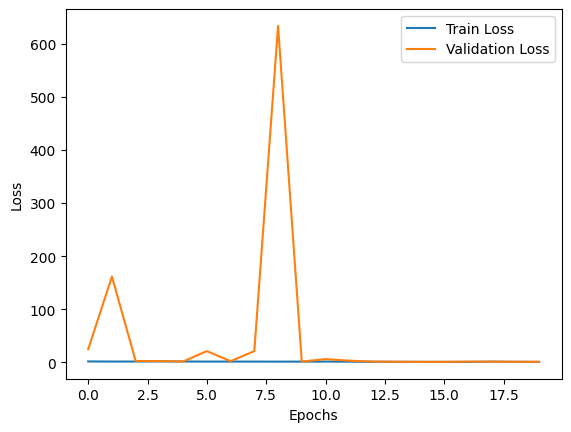

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=20,
    verbose=1
)


Epoch 1/20


c:\Users\prajw\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 328s 407ms/step - accuracy: 0.6190 - loss: 1.1156 - val_accuracy: 0.6377 - val_loss: 1.0832
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 318s 407ms/step - accuracy: 0.6188 - loss: 1.1268 - val_accuracy: 0.5993 - val_loss: 1.1700
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 317s 405ms/step - accuracy: 0.6174 - loss: 1.1059 - val_accuracy: 0.6168 - val_loss: 1.1010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 316s 404ms/step - accuracy: 0.6133 - loss: 1.1264 - val_accuracy: 0.4194 - val_loss: 3.3267
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 316s 404ms/step - accuracy: 0.6330 - loss: 1.0668 - val_accuracy: 0.5709 - val_loss: 1.2636
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 319s 408ms/step - accuracy: 0.6525 - loss: 1.0048 - val_accuracy: 0.6809 - val_loss: 0.9275
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 314s 402ms/step - accuracy: 0.6868 - loss: 0.8874 - val_accuracy: 0.6713 - val_loss: 0.9434
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 314s 402ms/step - accuracy: 0.6945 - loss: 0.89

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.001 * (0.1 ** (epoch // 10))
)
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[lr_schedule],
    verbose=1
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 303s 387ms/step - accuracy: 0.8266 - loss: 0.5016 - val_accuracy: 0.7678 - val_loss: 0.8169 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 302s 386ms/step - accuracy: 0.8618 - loss: 0.3914 - val_accuracy: 0.7467 - val_loss: 1.0503 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 303s 387ms/step - accuracy: 0.8767 - loss: 0.3528 - val_accuracy: 0.7662 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 303s 387ms/step - accuracy: 0.9058 - loss: 0.2761 - val_accuracy: 0.7854 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 305s 390ms/step - accuracy: 0.9040 - loss: 0.2735 - val_accuracy: 0.7887 - val_loss: 0.7596 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 304s 389ms/step - accuracy: 0.9475 - loss: 0.1503 - val_accuracy: 0.7638 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 305s 390ms/step - accura